In [2]:
#https://aleksandarhaber.com/disciplined-kalman-filter-implementation-in-python-by-using-object-oriented-approach/

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Nejdříve zrekapitulujeme Kalmanův filtr. 

Dle následující ilustrace je možné vidět, že nejdříve provedeme propagaci dynamiky systému ze stavu a posteriori do stavu a priori. Dále provedeme měření a za pomocí recursive least square error vypočítame a nový state estimate a covariance matrix.
<img src="Images/Kalman_fileter_ilustration.png"  width = 600 height=300 />
Toto je provedeno dle následujících rovnic. 
<img src="Images/Kalman_fileter_steps.png"  width = 600 height=200 />

<p>
Existuje auto, která má svojí počáteční pozici. Pro naše účely se může pohybovat jen jedním směrem v prostoru, tedy nemůže zatáčet a nebereme v potaz ani reliéf terénu a pohyb nahoru, či dolu. Auto má počáteční rychlost pohybu. <b>Dalším atributem je zrychlení auta, které zůstává stejné po celou dobu. </b>
</p>
<img src="Images/car_moving.svg"  width = 800 height=300 />

Protože chceme modelovat reálný systém vytvoříme sady dat. První data je ideální, vypočítaná podle rovnice z kynetiky. Druhá sada dat vychází z první, ale obsahuje noise, který simuluje reálná měření. Budeme postupovat podle rovnice:
<img src="Images/Kynetics.png"  width = 200 height=300 />

Chceme odhadnout parametry pozice (x, x1), rychlost (c,x2), zrychlení (a,x3) z měření. 

Poslední rovnice, kterou potřebujeme je:
<img src="Images/Kalman_fileter_state_forumla.png"  width = 200 height=300 />

In [4]:
class KalmanFilter(object):
     
    # x0 - initial guess of the state vector 
    # P0 - initial guess of the covariance matrix of the state estimation error
    # A,B,C - system matrices describing the system model
    # Q - covariance matrix of the process noise 
    # R - covariance matrix of the measurement noise
     
    def __init__(self,x0,P0,A,B,C,Q,R):
         
        # initialize vectors and matrices
        self.x0=x0
        self.P0=P0
        self.A=A
        self.B=B
        self.C=C
        self.Q=Q
        self.R=R
         
        # this variable is used to track the current time step k of the estimator 
        # after every measurement arrives, this variables is incremented for +1 
        self.currentTimeStep=0
         
        # this list is used to store the a posteriori estimates xk^{+} starting from the initial estimate 
        # note: list starts from x0^{+}=x0 - where x0 is an initial guess of the estimate
        self.estimates_aposteriori=[]
        self.estimates_aposteriori.append(x0)
         
        # this list is used to store the a apriori estimates xk^{-} starting from x1^{-}
        # note: x0^{-} does not exist, that is, the list starts from x1^{-}
        self.estimates_apriori=[]
         
        # this list is used to store the a posteriori estimation error covariance matrices Pk^{+}
        # note: list starts from P0^{+}=P0, where P0 is the initial guess of the covariance
        self.estimationErrorCovarianceMatricesAposteriori=[]
        self.estimationErrorCovarianceMatricesAposteriori.append(P0)
         
        # this list is used to store the a priori estimation error covariance matrices Pk^{-}
        # note: list starts from P1^{-}, that is, P0^{-} does not exist
        self.estimationErrorCovarianceMatricesApriori=[]
         
        # this list is used to store the gain matrices Kk
        self.gainMatrices=[]
          
        # this list is used to store prediction errors error_k=y_k-C*xk^{-}
        self.errors=[]
         
    # this function propagates x_{k-1}^{+} through the model to compute x_{k}^{-}
    # this function also propagates P_{k-1}^{+} through the covariance model to compute P_{k}^{-}
    # at the end this function increments the time index currentTimeStep for +1
    def propagateDynamics(self,inputValue):
         
        xk_minus=self.A*self.estimates_aposteriori[self.currentTimeStep]+self.B*inputValue
        Pk_minus=self.A*self.estimationErrorCovarianceMatricesAposteriori[self.currentTimeStep]*(self.A.T)+self.Q
         
        self.estimates_apriori.append(xk_minus)
        self.estimationErrorCovarianceMatricesApriori.append(Pk_minus)
         
        self.currentTimeStep=self.currentTimeStep+1
     
    # this function should be called after propagateDynamics() because the time step should be increased and states and covariances should be propagated         
    def computeAposterioriEstimate(self,currentMeasurement):
        import numpy as np
        # gain matrix
        Kk=self.estimationErrorCovarianceMatricesApriori[self.currentTimeStep-1]*(self.C.T)*np.linalg.inv(self.R+self.C*self.estimationErrorCovarianceMatricesApriori[self.currentTimeStep-1]*(self.C.T))
         
        # prediction error
        error_k=currentMeasurement-self.C*self.estimates_apriori[self.currentTimeStep-1]
        # a posteriori estimate
        xk_plus=self.estimates_apriori[self.currentTimeStep-1]+Kk*error_k
         
        # a posteriori matrix update 
        IminusKkC=np.matrix(np.eye(self.x0.shape[0]))-Kk*self.C
        Pk_plus=IminusKkC*self.estimationErrorCovarianceMatricesApriori[self.currentTimeStep-1]*(IminusKkC.T)+Kk*(self.R)*(Kk.T)
         
        # update the lists that store the vectors and matrices
        self.gainMatrices.append(Kk)
        self.errors.append(error_k)
        self.estimates_aposteriori.append(xk_plus)
        self.estimationErrorCovarianceMatricesAposteriori.append(Pk_plus)

In [5]:
# discretization step 
h=0.1
# initial values for the simulation
initialPosition=10
initialVelocity=5
# acceleration
acceleration=0.5
# measurement noise standard deviation
noiseStd=1;
# number of discretization time steps
numberTimeSteps=100

In [6]:
# define the system matrices - Newtonian system
# system matrices and covariances

# Discretized matrix 
A=np.matrix([[1,h,0.5*(h**2)],[0, 1, h],[0,0,1]])
# Its zero, because I dont have any external input
B=np.matrix([[0],[0],[0]])
# Position, velocity, acceleration... We measure only posisition
C=np.matrix([[1,0,0]])

# Measurement noise covariance matrix
R=1*np.matrix([[1]])
# Process noise covariance matrix
Q=np.matrix(np.zeros((3,3)))
 
#guess of the initial estimate
x0=np.matrix([[0],[0],[0]])
# initial covariance matrix 
P0=1*np.matrix(np.eye(3))

In [7]:
A

matrix([[1.   , 0.1  , 0.005],
        [0.   , 1.   , 0.1  ],
        [0.   , 0.   , 1.   ]])

In [8]:
B

matrix([[0],
        [0],
        [0]])

In [9]:
C

matrix([[1, 0, 0]])

In [10]:
R

matrix([[1]])

In [11]:
Q

matrix([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [12]:
x0

matrix([[0],
        [0],
        [0]])

In [13]:
P0

matrix([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

In [14]:
# time vector for simulation
timeVector=np.linspace(0,(numberTimeSteps-1)*h,numberTimeSteps)
 
# vector used to store the simulated position
position=np.zeros(np.size(timeVector))
velocity=np.zeros(np.size(timeVector))
 
# simulate the system behavior
for i in np.arange(np.size(timeVector)):
    position[i]=initialPosition+initialVelocity*timeVector[i]+(acceleration*timeVector[i]**2)/2
    velocity[i]=initialVelocity+acceleration*timeVector[i]
     
# add the measurement noise 
positionNoisy=position+noiseStd*np.random.randn(np.size(timeVector))

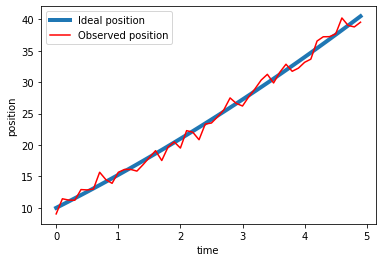

In [15]:
# verify the position vector by plotting the results
plotStep=numberTimeSteps//2
plt.plot(timeVector[0:plotStep],position[0:plotStep],linewidth=4, label='Ideal position')
plt.plot(timeVector[0:plotStep],positionNoisy[0:plotStep],'r', label='Observed position')
plt.xlabel('time')
plt.ylabel('position')
plt.legend()
plt.savefig('data.png',dpi=300)
plt.show()

In [16]:
positionNoisy[0]

9.034953998675663

In [35]:
#create a Kalman filter object 
KalmanFilterObject=KalmanFilter(x0,P0,A,B,C,Q,R)
inputValue=np.matrix([[0]])
# simulate online prediction
for j in np.arange(np.size(timeVector)):
    KalmanFilterObject.propagateDynamics(inputValue)
    KalmanFilterObject.computeAposterioriEstimate(positionNoisy[j])
    
KalmanFilterObject.estimates_aposteriori

[matrix([[0],
         [0],
         [0]]),
 matrix([[5.28436903],
         [0.52580786],
         [0.0261596 ]]),
 matrix([[6.53800363],
         [0.87935877],
         [0.06628082]]),
 matrix([[7.72101895],
         [1.49179318],
         [0.17247703]]),
 matrix([[8.2433016 ],
         [1.82032867],
         [0.24455074]]),
 matrix([[9.23622395],
         [2.72679925],
         [0.49373267]]),
 matrix([[10.35944313],
         [ 3.86164277],
         [ 0.8499788 ]]),
 matrix([[11.12693209],
         [ 4.47527932],
         [ 1.0449636 ]]),
 matrix([[11.78975968],
         [ 4.88798511],
         [ 1.16974762]]),
 matrix([[12.78202861],
         [ 5.74772078],
         [ 1.49410416]]),
 matrix([[13.38135789],
         [ 5.92265082],
         [ 1.50596225]]),
 matrix([[14.03738938],
         [ 6.15652485],
         [ 1.54668889]]),
 matrix([[14.83640429],
         [ 6.56789229],
         [ 1.67760193]]),
 matrix([[15.55420757],
         [ 6.81143102],
         [ 1.71758131]]),
 matrix([

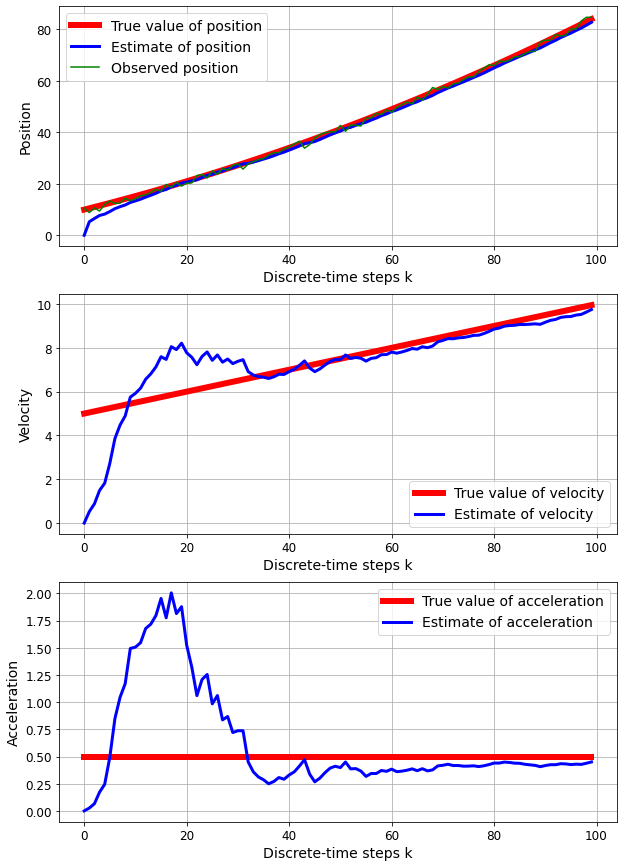

In [39]:
# extract the state estimates in order to plot the results
estimate1=[]
estimate2=[]
estimate3=[]    
for j in np.arange(np.size(timeVector)):
    estimate1.append(KalmanFilterObject.estimates_aposteriori[j][0,0])
    estimate2.append(KalmanFilterObject.estimates_aposteriori[j][1,0])
    estimate3.append(KalmanFilterObject.estimates_aposteriori[j][2,0])
     
# create vectors corresponding to the true values in order to plot the results
estimate1true=position
estimate2true=velocity
estimate3true=acceleration*np.ones(np.size(timeVector))
 
# plot the results
steps=np.arange(np.size(timeVector))
fig, ax = plt.subplots(3,1,figsize=(10,15))
ax[0].plot(steps,estimate1true,color='red',linestyle='-',linewidth=6,label='True value of position')
ax[0].plot(steps,estimate1,color='blue',linestyle='-',linewidth=3,label='Estimate of position')
ax[0].plot(steps,positionNoisy,'green', label='Observed position')
ax[0].set_xlabel("Discrete-time steps k",fontsize=14)
ax[0].set_ylabel("Position",fontsize=14)
ax[0].tick_params(axis='both',labelsize=12)
#ax[0].set_yscale('log')
#ax[0].set_ylim(98,102)  
ax[0].grid()
ax[0].legend(fontsize=14)
 
ax[1].plot(steps,estimate2true,color='red',linestyle='-',linewidth=6,label='True value of velocity')
ax[1].plot(steps,estimate2,color='blue',linestyle='-',linewidth=3,label='Estimate of velocity')
ax[1].set_xlabel("Discrete-time steps k",fontsize=14)
ax[1].set_ylabel("Velocity",fontsize=14)
ax[1].tick_params(axis='both',labelsize=12)
#ax[0].set_yscale('log')
#ax[1].set_ylim(0,2)  
ax[1].grid()
ax[1].legend(fontsize=14)
 
ax[2].plot(steps,estimate3true,color='red',linestyle='-',linewidth=6,label='True value of acceleration')
ax[2].plot(steps,estimate3,color='blue',linestyle='-',linewidth=3,label='Estimate of acceleration')
ax[2].set_xlabel("Discrete-time steps k",fontsize=14)
ax[2].set_ylabel("Acceleration",fontsize=14)
ax[2].tick_params(axis='both',labelsize=12)
#ax[0].set_yscale('log')
#ax[1].set_ylim(0,2)  
ax[2].grid()
ax[2].legend(fontsize=14)
 
plt.show()